In [76]:
import pyro
import pandas as pd
import numpy as np
import torch
import math
import os
import matplotlib.pyplot as plt
from pyro.infer import SVI, Predictive, TraceEnum_ELBO, config_enumerate
from pyro.optim import ClippedAdam
import pyro.distributions as dist
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error

from helper_functions.Clean_data import create_summed_df
from helper_functions.Preprocess_df import standardize_input, standardize_tensor, reverse_standardize_tensor
from helper_functions.utils import split_patient_level, summarize_columns, save_model_and_losses

In [ ]:
# set random seed for reproducibility
np.random.seed(42)
pyro.set_rng_seed(0)
torch.set_default_dtype(torch.float32)

weight_var= 0.001
experiment_name = f"testing_pca_mu_clamp_lower_var_alpha_{weight_var:.4f}_all_data"
save_dir = os.path.join("outputs", experiment_name)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

## Load data and prepare it

In [2]:
if not os.path.exists("data/CaseRigshospitalet_summed.parquet"):
    print("Creating data file")
    create_summed_df()
print("Loading data file")
df = pd.read_parquet("data/CaseRigshospitalet_summed.parquet")

print("Number of data points ", len(df))
print("Number of patients ", len(df["Patient ID"].unique()))
summarize_columns(df)

Loading data file
Number of data points  497198
Number of patients  331647
                           name     dtype  unique  size (MB)
0                    Patient ID  category  331647         30
1           Aktionsdiagnosekode  category    8167          1
2  totalDiagnoseKontaktVarighed   float32    8160          1
3                antalKontakter     int64     141          3
4                antalDiagnoser     int64      17          3
5                         alder   Float64   14014          4
6                        gender  category       4          0
7                    civilStand  category       4          0
8          distanceToHospitalKM   float64    1772          3
Total size (excluding "embedding"): 50.595398902893066 MB


### Create train and test data split

In [3]:
total_samples=None
(x_emb_train, d_demo_train, v_time_train, c_count_train), (x_emb_test, d_demo_test, v_time_test, c_count_test) = split_patient_level(df, total_samples=total_samples)

Demographic columns: ['alder', 'distanceToHospitalKM', 'gender_Kvinde', 'gender_Mand', 'gender_Ukendt', 'civilStand_Fraskilt', 'civilStand_Gift', 'civilStand_Ugift']


### Preprocess data
First, we standardize the input $x$ and $d$. Only age and distance is standardized of the $d$ since the other parts are one-hot-encodings. Then a PCA is done one the input $x$ to diminish the dimensions of the bert embeddings of the text, $x$, still covering 95% of the variance. 

In [4]:
x_emb_train_pca, x_emb_test_pca, d_demo_train, d_demo_test = standardize_input(x_emb_train, x_emb_test, d_demo_train, d_demo_test)
print("Standardized x_emb_train shape: ", x_emb_train_pca.shape)
print("Standardized x_emb_test shape: ", x_emb_test_pca.shape)
print("Standardized d_demo_train shape: ", d_demo_train.shape)  

Standardized x_emb_train shape:  torch.Size([397607, 151])
Standardized x_emb_test shape:  torch.Size([99591, 151])
Standardized d_demo_train shape:  torch.Size([397607, 8])


The output visitation time, $v$, is log transformed (to allow use of a normal function to estimate) and then standardized. The output visit count is not standardized as it does not make sense for count data. We plot the different versions of $v$.

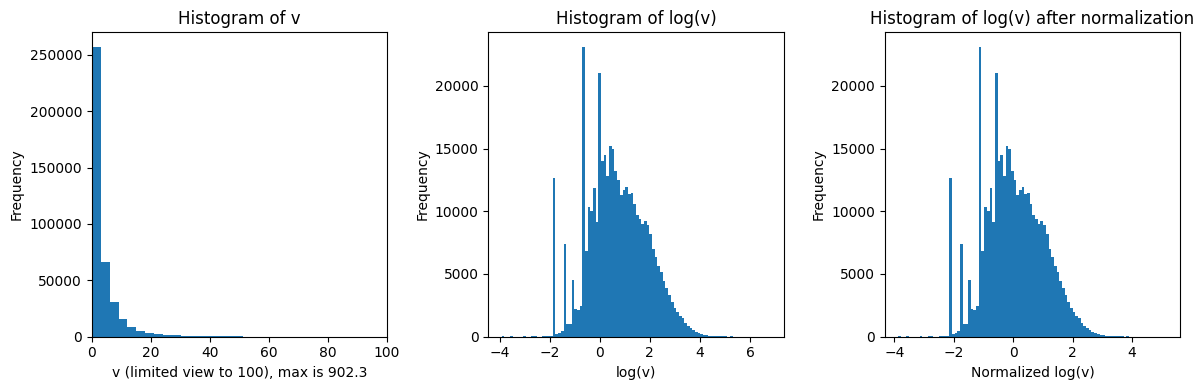

In [5]:

fig, ax = plt.subplots(1,3, figsize=(12, 4))
ax[0].hist(v_time_train, bins=300)
ax[0].set_title("Histogram of v")
ax[0].set_xlabel(f"v (limited view to 100), max is {torch.max(v_time_train):.1f}")
ax[0].set_ylabel("Frequency")
ax[0].set_xlim(0, 100)

v_time_train_log = torch.log(v_time_train)
#plot histogram of v_time_train_log
ax[1].hist(v_time_train_log.cpu().numpy(), bins=100)
ax[1].set_title("Histogram of log(v)")
ax[1].set_xlabel("log(v)")
ax[1].set_ylabel("Frequency")

v_time_train_log, v_time_mean, v_time_std = standardize_tensor(v_time_train_log)
ax[2].hist(v_time_train_log.cpu().numpy(), bins=100)
ax[2].set_title("Histogram of log(v) after normalization")
ax[2].set_xlabel("Normalized log(v)")
ax[2].set_ylabel("Frequency")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "v_time_histograms.pdf"))
plt.show()

v_time_test_log = torch.log(v_time_test)
v_time_test_log, _, _ = standardize_tensor(v_time_test_log, v_time_mean, v_time_std)


## Train

The generative process we are training is below. 

**Generative Process:**

1) Draw $\theta \sim \text{Dirichlet}(\alpha)$

2) For each group, $g$, in $G$:

    2a) Draw $\beta_g \sim \mathcal{N}(0,\tau \cdot \bm{I}_{K+1})$

    2b) Draw $\bm\gamma_0^g \sim \mathcal{N}(\log(\mathbb{E}[\bm c]),\tau)$

    2b) Draw $\gamma^g_{K-1} \sim \mathcal{N}(0,\tau \cdot \bm{I}_{K})$

    2c) Draw $\sigma_g \sim \text{HalfCauchy}(5)$

3) For each patient unique diagnosis record, $r$, in $\bm R$:

    3a) Draw group assignment $\bm{g}_r \sim \text{Categorical}(\theta)$

    3b) $\tilde{\mu} = \beta_{0}^r + \bm{\beta}_x^r \bm{x}_p + \bm{\beta}_d^r \bm{d}_p$
    
    3c) $\tilde{\lambda} = \exp (\gamma_{0}^r + \bm{\gamma}_x^r \bm{x}_r + \bm{\gamma}_d^r \bm{d}_r)$
    
    3d) Draw $\log \bm{v}_r \sim \mathcal{N}(\tilde{\mu}, \sigma_{g_r})$ 
    
    3e) Draw $\bm{c}_r \sim \text{Poisson}(\tilde{\lambda})$ 

The $\gamma_0$ are initialized with a prior with the empiric average. The $\log \lambda$ is clamped within $[-5.0, 5.4]$ and $\mu$ is clamped within $[-5.0, 5.0]$ matching the min and max values of the empirical distribution. The model is defined below as well as a guide for training the model with stochastical variational inference.

In [6]:
# Assume data tensors:
# x: [R, D_x] text embeddings
# d: [R, D_d] demographic features
# v: [R] visitation duration, continuous outcome
# c: [R] visitation count, positive integer outcome

torch.set_default_dtype(torch.float32)

# Model definition
@config_enumerate(default="parallel")              # ← enable enumeration
def MixtureModel(x, d, v, c, G=10, device="cpu", batch_size=None):
    x = x.to(dtype=torch.float32, device=device)
    d = d.to(dtype=torch.float32, device=device)
    if v is not None:
        v = v.to(dtype=torch.float32, device=device)
    if c is not None:
        c = c.to(dtype=torch.float32, device=device)

    R, D_x = x.shape
    _, D_d = d.shape

    # Dirichlet prior over cluster proportions
    alpha = torch.ones(G, device=device, dtype=torch.float32)/G
    theta = pyro.sample("theta", dist.Dirichlet(alpha))

    # Group-specific parameters
    with pyro.plate("group", G):
        # Regression weights for visitation duration v
        beta0 = pyro.sample("beta0", dist.Normal(torch.tensor(0., device=device), torch.tensor(weight_var, device=device)))
        beta_x = pyro.sample("beta_x", dist.Normal(torch.zeros(D_x, device=device), torch.tensor(weight_var, device=device)).to_event(1))
        beta_d = pyro.sample("beta_d", dist.Normal(torch.zeros(D_d, device=device), torch.tensor(weight_var, device=device)).to_event(1))
        sigma = pyro.sample("sigma", dist.HalfCauchy(scale=torch.tensor(5., device=device)))

        # Regression weights for count of c (log-rate)
        prior_mean_count = 1.3  # Adjust this based on your data
        gamma0 = pyro.sample("gamma0", dist.Normal(torch.tensor(math.log(prior_mean_count), device=device), torch.tensor(weight_var, device=device)))
        gamma_x = pyro.sample("gamma_x", dist.Normal(torch.zeros(D_x, device=device), torch.tensor(weight_var, device=device)).to_event(1))
        gamma_d = pyro.sample("gamma_d", dist.Normal(torch.zeros(D_d, device=device), torch.tensor(weight_var, device=device)).to_event(1))

    with pyro.plate("records", R, subsample_size=batch_size) as ind:
        x_b, d_b = x[ind], d[ind]
        
        if v is not None:
            v_b = v[ind]
        else:
            v_b = None

        if c is not None:
            c_b = c[ind]
        else:
            c_b = None

        # Mixture assignment
        g = pyro.sample("g", dist.Categorical(theta), infer={"enumerate":"parallel"})

        # Select parameters for each datum
        bt0 = beta0[g]
        btx = beta_x[g]
        btd = beta_d[g]
        sigma = sigma[g]

        bv0 = gamma0[g]
        bvx = gamma_x[g]
        bvd = gamma_d[g]

        mu_v    = bt0 + (btx * x_b).sum(-1) + (btd * d_b).sum(-1)
        log_lambda = bv0 + (bvx * x_b).sum(-1) + (bvd * d_b).sum(-1)
        log_lambda = torch.clamp(log_lambda, -5.0, 5.4)
        mu_v = torch.clamp(mu_v, -5.0, 5.0)
        
        # Observations
        pyro.sample("obs_logv", dist.Normal(mu_v, sigma), obs=v_b)
        pyro.sample("obs_c", dist.Poisson(log_lambda.exp()), obs=c_b)
        

# Guide (Mean-field VI)
def MixtureModelGuide(x,d, v=None, c=None, G=10, device="cpu", batch_size=None):
    x = x.to(device=device, dtype=torch.float32)
    d = d.to(device=device, dtype=torch.float32)

    N, D_x = x.shape
    _, D_d = d.shape
    
    # Learnable Dirichlet concentration
    q_alpha = pyro.param("q_alpha", torch.ones(G, dtype=torch.float32, device=device), constraint=dist.constraints.positive)
    theta = pyro.sample("theta", dist.Dirichlet(q_alpha))

    # Group params
    with pyro.plate("group", G):
        for name, shape, constraint in [
            ("beta0", [G], None),
            ("gamma0", [G], None)
        ]:
            pyro.param(f"loc_{name}", torch.zeros(*shape, device=device , dtype=torch.float32))
            pyro.param(f"scale_{name}", torch.ones(*shape, device=device, dtype=torch.float32), constraint=dist.constraints.positive)
            pyro.sample(name, dist.Normal(pyro.param(f"loc_{name}"), pyro.param(f"scale_{name}")))

        #pyro.param("loc_sigma", torch.zeros(G))
        pyro.param("scale_sigma", torch.ones(G, device=device, dtype=torch.float32), constraint=dist.constraints.positive)
        pyro.sample("sigma", dist.HalfCauchy(pyro.param("scale_sigma")))

        pyro.param("loc_beta_x", torch.zeros(G, D_x, dtype=torch.float32, device=device))
        pyro.param("scale_beta_x", torch.ones(G, D_x, dtype=torch.float32, device=device), constraint=dist.constraints.positive)
        pyro.sample("beta_x", dist.Normal(pyro.param("loc_beta_x"), pyro.param("scale_beta_x")).to_event(1))

        pyro.param("loc_beta_d", torch.zeros(G, D_d, dtype=torch.float32, device=device))
        pyro.param("scale_beta_d", torch.ones(G, D_d, dtype=torch.float32, device=device), constraint=dist.constraints.positive)
        pyro.sample("beta_d", dist.Normal(pyro.param("loc_beta_d"), pyro.param("scale_beta_d")).to_event(1))

        pyro.param("loc_gamma_x", torch.zeros(G, D_x,dtype=torch.float32, device=device))
        pyro.param("scale_gamma_x", torch.ones(G, D_x,dtype=torch.float32, device=device), constraint=dist.constraints.positive)
        pyro.sample("gamma_x", dist.Normal(pyro.param("loc_gamma_x"), pyro.param("scale_gamma_x")).to_event(1))

        pyro.param("loc_gamma_d", torch.zeros(G, D_d,dtype=torch.float32, device=device))
        pyro.param("scale_gamma_d", torch.ones(G, D_d,dtype=torch.float32, device=device), constraint=dist.constraints.positive)
        pyro.sample("gamma_d", dist.Normal(pyro.param("loc_gamma_d"), pyro.param("scale_gamma_d")).to_event(1))

The model is now trained using Stochastical Variational Inference (SVI). 

In [7]:
#Set device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.set_default_device(device)
cuda_gen = torch.Generator(device=device).manual_seed(42)
x_emb_train, x_emb_train_pca, d_demo_train, v_time_train, c_count_train, v_time_train_log = [
    tensor.to(device) for tensor in [x_emb_train, x_emb_train_pca, d_demo_train, v_time_train, c_count_train, v_time_train_log]
]

Using device: cuda


In [8]:
# Setup DataLoader
batch_size = 2**11 #max is 2**17
dataset = TensorDataset(x_emb_train_pca, d_demo_train, v_time_train_log, c_count_train)
dataloader = DataLoader(dataset, 
                        batch_size=batch_size, 
                        shuffle=True, 
                        generator=cuda_gen, 
                        num_workers=4,
                        persistent_workers=True
                    )

G=10
R = len(x_emb_train)

# Setup SVI
optimizer = ClippedAdam({"lr": 1e-4})
svi = SVI(MixtureModel, MixtureModelGuide, optimizer, loss=TraceEnum_ELBO(max_plate_nesting=1))

losses = []
# Training loop
def train_batch(num_epochs=1000):
    for epoch in range(num_epochs):
        total_loss = 0.0
        for x_b, d_b, v_b, c_b in dataloader:
            total_loss += svi.step(x_b, d_b, v_b, c_b, G, device, batch_size=len(x_b))
        losses.append(total_loss)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch} loss = {total_loss:.2f}")

# Run batch training:
train_batch(num_epochs=1000)


Epoch 0 loss = 306586228224.00
Epoch 10 loss = 207243908160.00
Epoch 20 loss = 140938316160.00
Epoch 30 loss = 95218088064.00
Epoch 40 loss = 64725215584.00
Epoch 50 loss = 43901922864.00
Epoch 60 loss = 29914374224.00
Epoch 70 loss = 20342942064.00
Epoch 80 loss = 13804239744.00
Epoch 90 loss = 9379539384.00
Epoch 100 loss = 6376273296.00
Epoch 110 loss = 4339529924.00
Epoch 120 loss = 2944989384.00
Epoch 130 loss = 2005713629.00
Epoch 140 loss = 1372493428.50
Epoch 150 loss = 934112313.00
Epoch 160 loss = 635822440.25
Epoch 170 loss = 435292127.12
Epoch 180 loss = 298498516.62
Epoch 190 loss = 203334405.62
Epoch 200 loss = 140052978.69
Epoch 210 loss = 96141868.72
Epoch 220 loss = 66116225.78
Epoch 230 loss = 45495440.89
Epoch 240 loss = 31399343.91
Epoch 250 loss = 21670923.87
Epoch 260 loss = 14873046.66
Epoch 270 loss = 10172177.98
Epoch 280 loss = 6927796.86
Epoch 290 loss = 4625209.29
Epoch 300 loss = 3023551.54
Epoch 310 loss = 1820632.52
Epoch 320 loss = 1052460.22
Epoch 330 l

In [9]:
# If more training is needed, uncomment the following line:
#train_batch(num_epochs=1000)  # adjust epochs

In [10]:
num_steps = len(losses)

In [11]:
model_path = os.path.join(save_dir, f"model_params_{num_steps}.pt")
losses_path = os.path.join(save_dir, f"losses_{num_steps}.npy")
save_model_and_losses(svi, losses, model_path=model_path, losses_path=losses_path)

Model parameters saved to outputs\testing_pca_mu_clamp_lower_var_alpha_0.0010_all_data\model_params_1000.pt
Losses saved to outputs\testing_pca_mu_clamp_lower_var_alpha_0.0010_all_data\losses_1000.npy


### Plot of loss curves
We plot the loss curve for the training to see if convergence is achieved.

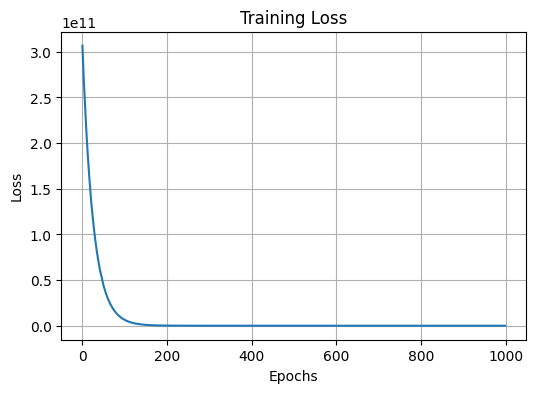

In [22]:
# plot loss
def plot_loss(losses):
    plt.figure(figsize=(6, 4))
    plt.plot(losses)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    #plt.yscale("log")
    plt.grid()
    plt.savefig(os.path.join(save_dir, f"loss_plot_{G}groups_{total_samples}samples_{num_steps}steps.pdf"))
    plt.show()

# Call the function to plot loss
plot_loss(losses)

## Predictions
The predictions are computed by sampling 200 samples from the trained model with the input from the test data. The mean is then taken of the 200 samples which we use as the prediction.

In [71]:
# Move things to device
x_emb_test_pca, d_demo_test, v_time_test, v_time_test_log, c_count_test, v_time_mean, v_time_std = [
    tensor.to(device).to(torch.float32) for tensor in [x_emb_test_pca, d_demo_test, v_time_test, v_time_test_log, c_count_test, v_time_mean, v_time_std]
]

# Draw posterior‐predictive samples
predictive = Predictive(
    MixtureModel,
    guide=MixtureModelGuide,
    num_samples=200,                      
    return_sites=["obs_logv", "obs_c", "g"]
)
samples = predictive(x_emb_test_pca, d_demo_test, None, None, G, device)

# Compute mean of predictions and reverse standardization and reverse log transformation
pred_v_log = samples["obs_logv"].mean(0)
pred_v_log = reverse_standardize_tensor(pred_v_log, v_time_mean, v_time_std)
pred_v = torch.exp(pred_v_log)
pred_v = pred_v.cpu().numpy()

# Get the “true” values by reversing the standardization and log transformation
v_time_test_log_reversed = reverse_standardize_tensor(v_time_test_log, v_time_mean, v_time_std)
true_v = torch.exp(v_time_test_log_reversed)
true_v   = true_v.cpu().numpy()

# Get predicted counts
pred_c = samples["obs_c"].mean(dim=0).cpu().numpy()
# Get true counts
true_c = c_count_test.cpu().numpy()

# First print some statistics
print("\nPredicted time spent:")
print("Total test predictions: ", len(pred_v))
print(f"Minimum {pred_v.min()} and maximum {pred_v.max()}")

print("\nPredicted counts:")
print("Total test predictions: ", len(pred_c))
print(f"Minimum {pred_c.min()} and maximum {pred_c.max()}")

# Compute RMSE
rmse_v = np.sqrt(mean_squared_error(true_v, pred_v))
rmse_c = np.sqrt(mean_squared_error(true_c, pred_c))

print(f"\nRMSE for visitation duration: {rmse_v:.2f}")
print(f"RMSE for visitation count: {rmse_c:.2f}")


Predicted time spent:
Total test predictions:  99591
Minimum 0.7849701046943665 and maximum 2.959291934967041

Predicted counts:
Total test predictions:  99591
Minimum 0.9549999833106995 and maximum 74.73500061035156

RMSE for visitation duration: 8.97
RMSE for visitation count: 7.17


We then plot the mean predictions vs. the true values.

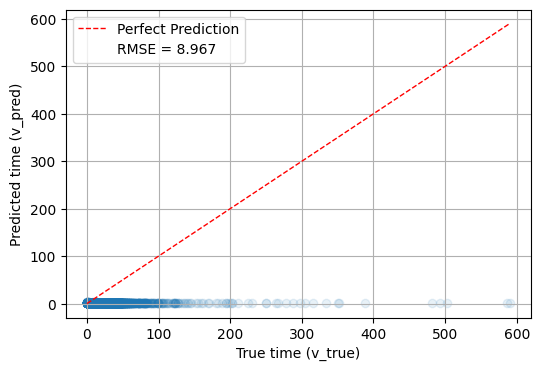

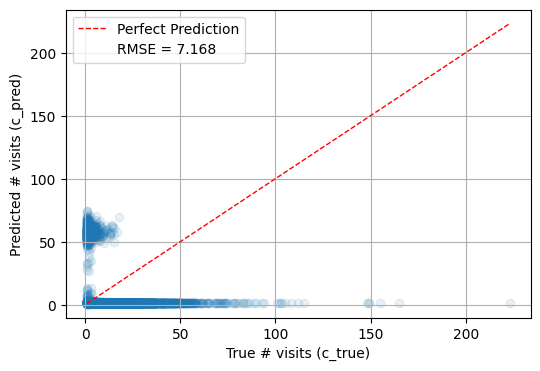

In [72]:
# Plot True vs Predicted for time
plt.figure(figsize=(6, 4))
plt.scatter(true_v, pred_v,  alpha=0.1)
plt.plot([true_v.min(), true_v.max()],
        [true_v.min(), true_v.max()],
            'r--', linewidth=1,label="Perfect Prediction")
plt.plot([], [], ' ', label=f"RMSE = {rmse_v:.3f}")

plt.xlabel("True time (v_true)")
plt.ylabel("Predicted time (v_pred)")
plt.legend()
plt.grid()
plt.savefig(os.path.join(save_dir,f"time_pred_true_{G}groups_{total_samples}samples_{num_steps}steps.pdf"))
plt.show()

# Plot True vs Predicted for visits
plt.figure(figsize=(6, 4))
plt.scatter(true_c, pred_c, alpha=0.1)
plt.plot([true_c.min(), true_c.max()],
         [true_c.min(), true_c.max()],
          'r--', linewidth=1, label="Perfect Prediction")
plt.plot([], [], ' ', label=f"RMSE = {rmse_c:.3f}")
plt.xlabel("True # visits (c_true)")
plt.ylabel("Predicted # visits (c_pred)")
plt.grid()
plt.legend()
plt.savefig(os.path.join(save_dir,f"count_pred_true_{G}groups_{total_samples}samples_{num_steps}steps.pdf"))
plt.show()

We also want to look at the distributions rather than the mean values of the predictions. 

In [73]:
# Reverse standardization and log transformation for visitation duration
pred_v_log_samples = samples["obs_logv"]  # shape: (num_samples, N)
pred_v_log_samples = reverse_standardize_tensor(pred_v_log_samples, v_time_mean, v_time_std)
pred_v_samples = torch.exp(pred_v_log_samples)
pred_v_samples = pred_v_samples.cpu().numpy() 

true_v_expanded = np.expand_dims(true_v, axis=0)  # Add a new axis at the beginning
true_v_copied = np.repeat(true_v_expanded, pred_v_samples.shape[0], axis=0)
print(true_v_copied.shape)
print(pred_v_samples.shape)

# Flatten the predictions and truths
true_v_flat = true_v_copied.flatten()
pred_v_flat = pred_v_samples.flatten()

true_c_expanded = np.expand_dims(true_c, axis=0)  # Add a new axis at the beginning
pred_c_ = samples["obs_c"].cpu().numpy()
pred_c_flat = pred_c_.flatten()
true_c_copied = np.repeat(true_c_expanded, pred_c_.shape[0], axis=0)
true_c_flat = true_c_copied.flatten()


(200, 99591)
(200, 99591)


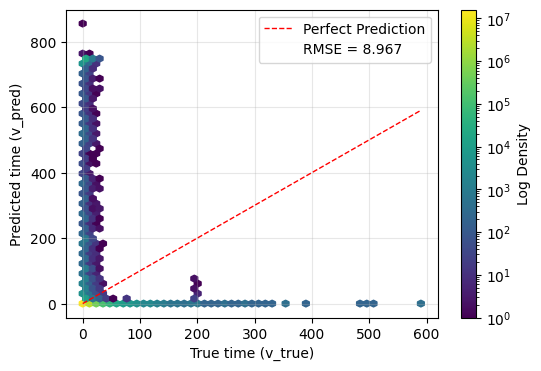

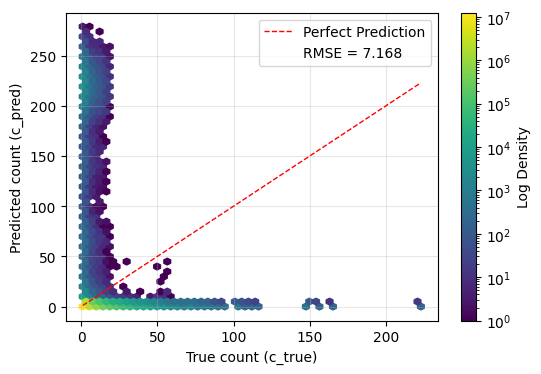

In [74]:
plt.figure(figsize=(6, 4))
hb = plt.hexbin(true_v_flat, pred_v_flat, gridsize=50, cmap='viridis', bins='log')  # bins='log' for log-scaling
plt.colorbar(label="Log Density")
plt.plot(
    [true_v_flat.min(), true_v_flat.max()],
    [true_v_flat.min(), true_v_flat.max()],
    'r--', linewidth=1, label="Perfect Prediction"
)
plt.plot([], [], ' ', label=f"RMSE = {rmse_v:.3f}")

plt.xlabel("True time (v_true)")
plt.ylabel("Predicted time (v_pred)")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(os.path.join(save_dir, "v_time_hexbin.png"))
plt.show()

# Plotting c count predictions
plt.figure(figsize=(6, 4))
hb = plt.hexbin(true_c_flat, pred_c_flat, gridsize=50, cmap='viridis', bins='log')  # bins='log' for log-scaling
plt.colorbar(label="Log Density")
plt.plot(
    [true_c_flat.min(), true_c_flat.max()],
    [true_c_flat.min(), true_c_flat.max()],
    'r--', linewidth=1, label="Perfect Prediction"
)
plt.plot([], [], ' ', label=f"RMSE = {rmse_c:.3f}")
plt.xlabel("True count (c_true)")
plt.ylabel("Predicted count (c_pred)")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(os.path.join(save_dir, "c_count_hexbin.png"))
plt.show()


We plot distribution per group to see if there is any difference.

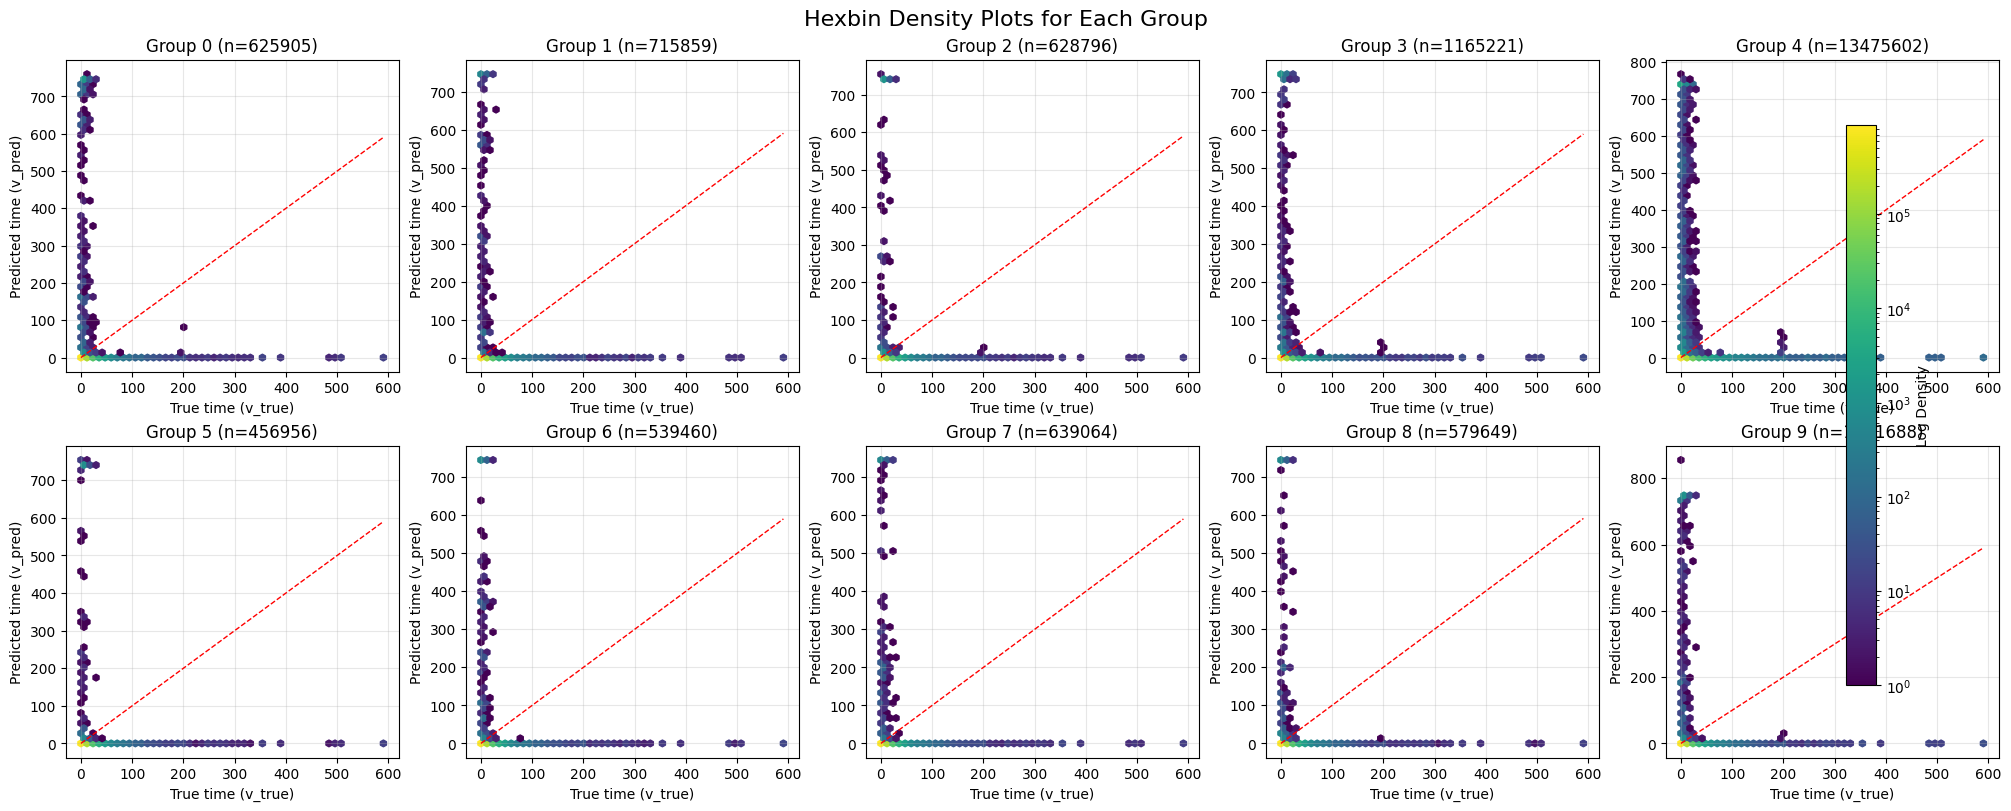

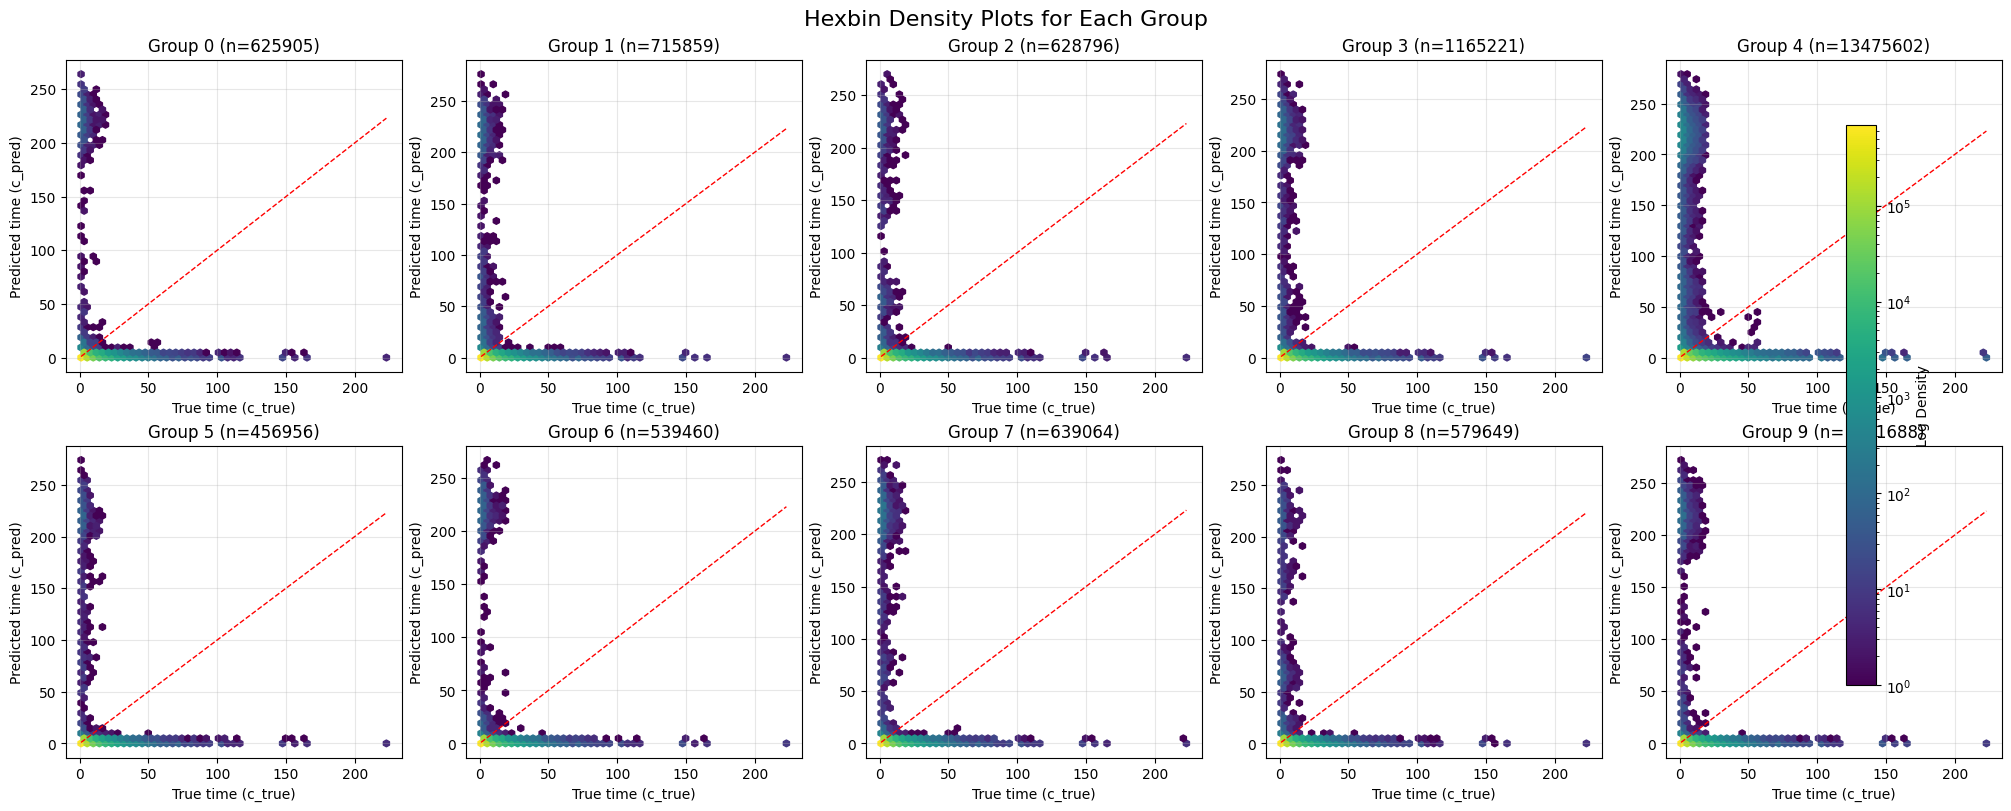

In [75]:
unique_groups = np.unique(group_assignments)
n_groups = unique_groups.size

fig, axs = plt.subplots(2, 5, figsize=(20, 8), constrained_layout=True)

for i, g in enumerate(unique_groups):
    ax = axs[i // 5, i % 5]

    # Mask data for this group
    mask = group_assignments == g
    true_v_group = true_v_flat[mask]
    pred_v_group = pred_v_flat[mask]

    # Hexbin plot for this group
    hb = ax.hexbin(
        true_v_group, pred_v_group, gridsize=50, cmap='viridis', bins='log'
    )
    ax.plot(
        [true_v_group.min(), true_v_group.max()],
        [true_v_group.min(), true_v_group.max()],
        'r--', linewidth=1
    )
    ax.set_title(f"Group {g} (n={mask.sum()})")
    ax.set_xlabel("True time (v_true)")
    ax.set_ylabel("Predicted time (v_pred)")
    ax.grid(alpha=0.3)

# Add a colorbar to the right of all plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.set_label("Log Density")

plt.suptitle("Hexbin Density Plots for Each Group", fontsize=16)
plt.savefig(os.path.join(save_dir, "v_time_hexbin_per_group.png"))
plt.show()

fig, axs = plt.subplots(2, 5, figsize=(20, 8), constrained_layout=True)

for i, g in enumerate(unique_groups):
    ax = axs[i // 5, i % 5]

    # Mask data for this group
    mask = group_assignments == g
    true_c_group = true_c_flat[mask]
    pred_c_group = pred_c_flat[mask]

    # Hexbin plot for this group
    hb = ax.hexbin(
        true_c_group, pred_c_group, gridsize=50, cmap='viridis', bins='log'
    )
    ax.plot(
        [true_c_group.min(), true_c_group.max()],
        [true_c_group.min(), true_c_group.max()],
        'r--', linewidth=1
    )
    ax.set_title(f"Group {g} (n={mask.sum()})")
    ax.set_xlabel("True time (c_true)")
    ax.set_ylabel("Predicted time (c_pred)")
    ax.grid(alpha=0.3)

# Add a colorbar to the right of all plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.set_label("Log Density")

plt.suptitle("Hexbin Density Plots for Each Group", fontsize=16)
plt.savefig(os.path.join(save_dir, "c_count_hexbin_per_group.png"))
plt.show()